In [51]:
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Input, Activation, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib

## Building the encoder

In [149]:
latent_dim = 20
feature_map = 32

In [150]:
encoder_input = Input(shape=(28,28,1))
encoder_layer1 = Conv2D(feature_map,(3,3))(encoder_input)
encoder_layer2 =  LeakyReLU()(encoder_layer1)
encoder_flatten = Flatten()(encoder_layer2)
encoder_layer3 = Dense(latent_dim)(encoder_flatten)

In [151]:
encoder = Model(encoder_input,encoder_layer3)

In [152]:
encoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                432660    
Total params: 432,980
Trainable params: 432,980
Non-trainable params: 0
_________________________________________________________________


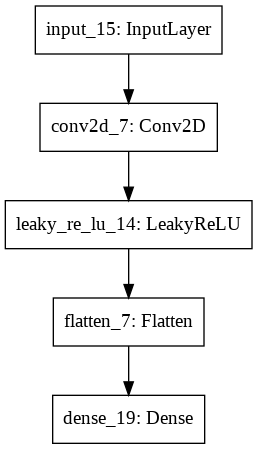

In [153]:
plot_model(encoder)

In [154]:
from tensorflow.keras import backend as K

In [155]:
volumeSize = K.int_shape(encoder_layer2)

In [156]:
volumeSize[1:] 

(26, 26, 32)

## Building the decoder

In [157]:
decoder_input = Input(shape=(latent_dim,))

decoder_layer1 = Dense(np.prod(volumeSize[1:]))(decoder_input) #Adding the no of neurons that equals to the no of neurons obtained after flattening
decoder_input_Reshaped = Reshape((volumeSize[1],volumeSize[2],volumeSize[3]))(decoder_layer1) #Resizing into a matrix for the next layer

decoder_layer_cnn = Conv2DTranspose(feature_map,(3,3))(decoder_input_Reshaped)
decoder_layer_actv = LeakyReLU()(decoder_layer_cnn)
decoder_layer_output = Dense(1)(decoder_layer_actv) #since one depth channel

In [158]:
decoder = Model(decoder_input,decoder_layer_output)

In [159]:
decoder.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 21632)             454272    
_________________________________________________________________
reshape_7 (Reshape)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
dense_21 (Dense)             (None, 28, 28, 1)         33        
Total params: 463,553
Trainable params: 463,553
Non-trainable params: 0
____________________________________________________

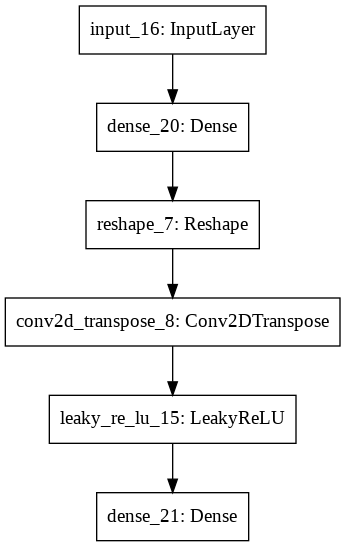

In [160]:
plot_model(decoder)

In [161]:
autoencoder = Model(encoder_input,decoder(encoder(encoder_input)))

In [162]:
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_19 (Functional)        (None, 20)                432980    
_________________________________________________________________
model_20 (Functional)        (None, 28, 28, 1)         463553    
Total params: 896,533
Trainable params: 896,533
Non-trainable params: 0
_________________________________________________________________


## Preparing Data with Noise

In [163]:
(x_train_orig,y_train),(x_test_orig,y_test) = load_data()

In [164]:
#Normalizing
x_train_orig = x_train_orig.astype('float32')/255
x_test_orig = x_test_orig.astype('float32')/255

In [165]:
#Adding noise by sampling from a random normal distribution
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=x_train_orig.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=x_test_orig.shape)
x_train = np.clip(x_train_orig + trainNoise, 0, 1)
x_test = np.clip(x_test_orig + testNoise, 0, 1)

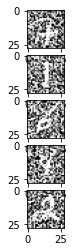

In [166]:
#Noisy input
num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_train.shape[0])    
    matplotlib.pyplot.subplot(num_images_to_show, 2, plot_ind)
    matplotlib.pyplot.imshow(x_train[rand_ind, :, :], cmap="gray")


In [167]:
#Adding another dimension
x_train = np.expand_dims(x_train,axis=-1)
x_test = np.expand_dims(x_test,axis=-1)

In [168]:
x_train.shape

(60000, 28, 28, 1)

In [169]:
#for the labels
x_train_label = np.expand_dims(x_train_orig,axis=-1)
x_test_label = np.expand_dims(x_test_orig,axis =-1)

In [170]:
x_train_label.shape

(60000, 28, 28, 1)

## Compiling

In [173]:
autoencoder.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

## Training

In [174]:
autoencoder.fit(x_train,x_train_label,batch_size = 256, epochs = 20 , validation_data=(x_test,x_test_label))

Epoch 1/20
235/235 [==============================] - 4s 14ms/step - loss: 0.0258 - val_loss: 0.0247
Epoch 2/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0243 - val_loss: 0.0236
Epoch 3/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 4/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0223 - val_loss: 0.0219
Epoch 5/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0216 - val_loss: 0.0215
Epoch 6/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0211 - val_loss: 0.0211
Epoch 7/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0206 - val_loss: 0.0207
Epoch 8/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0202 - val_loss: 0.0204
Epoch 9/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0199 - val_loss: 0.0202
Epoch 10/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0195 - val_lo

## Predicting

In [175]:
encoder_prediction = encoder.predict(x_train)

In [176]:
decoder_prediction = decoder.predict(encoder_prediction)

In [177]:
decoder_images =  decoder_prediction.reshape((decoder_prediction.shape[0],28,28))

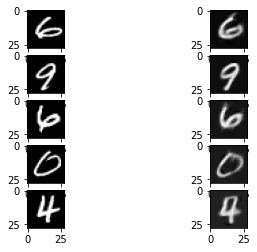

In [178]:
#Plotting the output
num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    matplotlib.pyplot.subplot(num_images_to_show, 2, plot_ind)
    matplotlib.pyplot.imshow(x_train_orig[rand_ind, :, :], cmap="gray")
    matplotlib.pyplot.subplot(num_images_to_show, 2, plot_ind+1)
    matplotlib.pyplot.imshow(decoder_images[rand_ind, :, :], cmap="gray")